# Preprocessing

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import Series, DataFrame
import pickle
import datetime
import math
from tqdm import tqdm
import os
import calendar
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import skew, norm
from xgboost.sklearn import XGBRegressor

pd.set_option('display.max_columns', None) # no truncate columns

In [4]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "data-visualization"
df = {}
for df_name in ['train', 'test', 'all', 'monthly']:
    with open(data_path_out+df_name+'_dv.obj', 'rb') as file:
        df[df_name] = pickle.load(file)
        
all_data = df['all']
train = df['train']
test = df['test']
monthly_sales = df['monthly']

In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Drop features

In [6]:
all_data = all_data.drop('Max_Gust_SpeedKm_h', axis=1)
# also implicitly drop NumberOfCustomers when spllitting all_data at the end
# and combined events when One Hot Encoding is performed

## Fill missing values

### Events

In [7]:
all_data.Events = all_data.Events.cat.add_categories('Normal')
train.Events = train.Events.cat.add_categories('Normal')

In [8]:
all_data.Events = all_data.Events.fillna('Normal')
print ('There are {} missing values of Events left'\
       .format(all_data['Events'].isna().sum(),
               all_data['Events'].isna().sum()/all_data.shape[0]*100))

#  JUST FOR VISUSALIZATION PURPOSES
train.Events = train.Events.fillna('Normal')
print ('There are {} missing values of Events left'\
       .format(train['Events'].isna().sum(),
               train['Events'].isna().sum()/all_data.shape[0]*100))

There are 0 missing values of Events left
There are 0 missing values of Events left


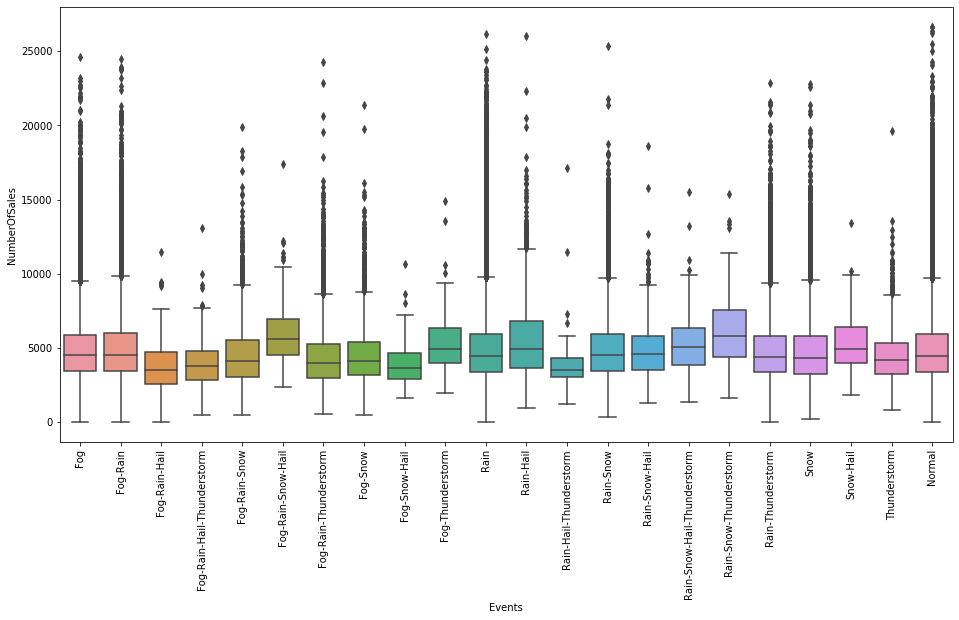

In [9]:
### ADDED NORMAL
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='Events', y="NumberOfSales", data=train[train.IsOpen == True])
plt.xticks(rotation=90);

### Visibility

Since the Visibility has a high negative correlation  with Humidity, a good imputation method could be to group data by Humidity and use the median value to fill in missing values.

Intuitively the minimum visibility corresponds to the maximum humidity and viceversa.

Some humidity levels could not have visiblity values, so a good solution could be to take the mean between the two adiacent values

In [10]:
all_data.isna().any()

StoreID                       False
Date                          False
IsHoliday                     False
IsOpen                        False
HasPromotions                 False
StoreType                     False
AssortmentType                False
NearestCompetitor             False
Region                        False
Region_AreaKM2                False
Region_GDP                    False
Region_PopulationK            False
CloudCover                     True
Events                        False
Max_Dew_PointC                False
Max_Humidity                  False
Max_Sea_Level_PressurehPa     False
Max_TemperatureC              False
Max_VisibilityKm               True
Max_Wind_SpeedKm_h            False
Mean_Dew_PointC               False
Mean_Humidity                 False
Mean_Sea_Level_PressurehPa    False
Mean_TemperatureC             False
Mean_VisibilityKm              True
Mean_Wind_SpeedKm_h           False
Min_Dew_PointC                False
Min_Humidity                

In [11]:
feature_to_predict = ['Mean_VisibilityKm', 'Max_VisibilityKm', 'Min_VisibilitykM', 'CloudCover']

cv_nans = False

In [12]:
if cv_nans == True:
    for feature in tqdm(feature_to_predict):
        drop_features = [f for f in feature_to_predict if f != feature]

        df_feature = pd.get_dummies(all_data).drop(['Date'] + drop_features, axis=1)

        nan_mask = df_feature[feature].isnull()
        feat_test = df_feature[nan_mask]
        feat_train = df_feature[-nan_mask]

        y_train = feat_train[feature]
        X_train = feat_train.drop(feature, axis=1)
        X_test = feat_test.drop(feature, axis=1)

        model = XGBRegressor(n_jobs=4, max_depth=9)
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        results = cross_val_score(model,X_train,y_train,cv=kfold,verbose=2)

        print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
              .format(feature, results.mean(), results.std()))

In [13]:
for feature in tqdm(feature_to_predict):
    drop_features = [f for f in feature_to_predict if f != feature]

    df_feature = pd.get_dummies(all_data).drop(['Date'] + drop_features, axis=1)
    
    nan_mask = df_feature[feature].isnull()
    feat_test = df_feature[nan_mask]
    feat_train = df_feature[-nan_mask]
    
    y_train = feat_train[feature]
    X_train = feat_train.drop(feature, axis=1)
    X_test = feat_test.drop(feature, axis=1)
    
    model = XGBRegressor(n_jobs=4, max_depth=9)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    
    nan_mask = all_data[feature].isnull()
    all_data.loc[nan_mask,feature] = predictions

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\rajee\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rajee\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:05:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 25%|████████████████████▊                                                              | 1/4 [02:30<07:31, 150.39s/it]

[19:07:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████████████████████████████████████████▌                                         | 2/4 [05:07<05:04, 152.32s/it]

[19:10:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [07:21<02:26, 146.96s/it]

[19:12:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [09:27<00:00, 141.94s/it]


## Region 2 missing time window
Fill missing data in datetime range 2017-07-04/2018-01-03 (extremes included).

In [14]:
process_region2 = False

### Window dates filling

In [15]:
if process_region2:
    # create date range dataframe
    date_missing_start = '2017-07-04'
    date_missing_end = '2018-01-03'

    date_range = pd.date_range(date_missing_start, date_missing_end)

    # create df and set dtypes
    df_region2 = pd.DataFrame(data={'Date': date_range, 'Region': '2'})

    df_region2.Date = pd.to_datetime(df_region2.Date)
    df_region2.Region = df_region2.Region.astype('category')

    print(df_region2.shape)
    df_region2.head()

#### Replacement by similar store

In [16]:
if process_region2:
    # HasPromotions (replacement with store 1006 since all are equal)
    df_region2['HasPromotions'] = all_data[all_data.StoreID == 1006]\
    .loc[(all_data.Date >= date_missing_start) & (all_data.Date <= date_missing_end)]\
    .HasPromotions.reset_index().drop('index', axis=1)

#### Replacement by most correlated region

In [17]:
if process_region2:
    # Group all_data by Region
    dic_all = {
        'IsHoliday': 'mean',
        'IsOpen': 'mean',
        'HasPromotions': 'mean',
        'NearestCompetitor': 'mean',
        'Region_AreaKM2': 'mean',
        'Region_GDP': 'mean',
        'Region_PopulationK': 'mean',
        'CloudCover': 'mean',
        'Max_Humidity': 'mean',
        'Max_Dew_PointC': 'mean',
        'Max_Sea_Level_PressurehPa': 'mean',
        'Max_TemperatureC': 'mean',
        'Max_VisibilityKm': 'mean',
        'Max_Wind_SpeedKm_h': 'mean',
        'Mean_Dew_PointC': 'mean',
        'Mean_Humidity': 'mean',
        'Mean_Sea_Level_PressurehPa': 'mean',
        'Mean_TemperatureC': 'mean',
        'Mean_VisibilityKm': 'mean',
        'Mean_Wind_SpeedKm_h': 'mean',
        'Min_Dew_PointC': 'mean',
        'Min_Humidity': 'mean',
        'Min_Sea_Level_PressurehPa': 'mean',
        'Min_TemperatureC': 'mean',
        'Min_VisibilitykM': 'mean',
        'Precipitationmm': 'mean',
        'WindDirDegrees': 'mean'}


    # Define train_data grouped by Region in common date range
    all_data_byRegion = all_data.groupby(['Region', pd.Grouper(key='Date', freq='D')])\
    .agg(dic_all).reset_index()

    all_data_common_byRegion =\
    all_data_byRegion.loc[(all_data_byRegion.Date >= '2016-03-01') &
                          (all_data_byRegion.Date <= '2017-07-03')]

    all_data_missing_byRegion =\
    all_data_byRegion[all_data_byRegion.Region != '2']\
    .loc[(all_data_byRegion.Date >= date_missing_start) &
         (all_data_byRegion.Date <= date_missing_end)]

    # Define train_data grouped by Region in common date range
    all_data_byRegion_except_region2 = all_data_common_byRegion[all_data_common_byRegion.Region != '2']
    all_data_byRegion_except_region2.Region.cat.remove_unused_categories(inplace=True)

In [18]:
if process_region2:
    # Replace by most correlated region
    median_correction = ['Max_TemperatureC', 'CloudCover', 'Max_Sea_Level_PressurehPa',
                         'Max_Wind_SpeedKm_h', 'Max_Dew_PointC', 'WindDirDegrees',
                         'Mean_Dew_PointC', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC',
                         'Mean_Wind_SpeedKm_h', 'Min_Dew_PointC', 'Min_Sea_Level_PressurehPa',
                         'Min_VisibilitykM']

    print('Most correlated region for the given feature')
    print('{:<30}{:10}{:>10}'.format('FEATURE', 'REGION', 'CORRELATION'))
    print('-' * (30+10+10))

    # get the date range
    for feature_name in median_correction:
        # compute correlation for each region wrt region 2 for current feature
        corr_byRegion = {}
        for region_name, region in all_data_byRegion_except_region2.groupby('Region'):
            region = region[feature_name]
            region_2 = all_data_common_byRegion[feature_name][all_data_common_byRegion.Region == '2']

            corr_byRegion[region_name] = pd.np.corrcoef(region_2, region)[1,0]

        # get region with max correlation for the current feature
        max_corr_region = max(corr_byRegion, key=corr_byRegion.get)

        print('{:<30}{:10}{:10.4f}'.format(feature_name, max_corr_region, corr_byRegion[max_corr_region]))

        # replace missing feature for date window with most correlated region feature 
        feature_column = all_data_missing_byRegion[all_data_missing_byRegion.Region == max_corr_region]\
        [feature_name].reset_index().drop('index', axis=1)

        df_region2 = pd.concat([df_region2, feature_column], axis=1)

#### Replacement by region 2 itself

In [19]:
if process_region2:
    # copy from Region 2: Region_AreaKM2, Region_GDP, Region_PopulationK
    for feature_name in ['Region_AreaKM2', 'Region_GDP', 'Region_PopulationK']:
        df_region2[feature_name] = all_data[all_data.Region == '2'][feature_name].unique()[0]

#### Replacement by single store from Region 2 and concatenation with dataset

In [20]:
if process_region2:
    # Add missing dates window to dataset
    print(all_data.shape)

    # add to all_data missing region 2 values
    for storeid in all_data[all_data.Region == '2'].StoreID.unique():    
        # copy from same stores from Region 2: StoreID, AssortmentType, NearestCompetitor, StoreType
        store_data = {
            'StoreID': np.array([storeid], dtype='uint16'),
            'AssortmentType': all_data[all_data.StoreID == storeid].AssortmentType.unique()[0],
            'NearestCompetitor': all_data[all_data.StoreID == storeid].NearestCompetitor.unique()[0],
            'StoreType': all_data[all_data.StoreID == storeid].StoreType.unique()[0]
        }

        # create 'storeid' column
        df_storeid = pd.DataFrame(data=store_data, index=np.arange(0, df_region2.shape[0]))

        df_storeid = pd.concat([df_region2, df_storeid], axis=1)

        # add to all_data df the missing values range for 'storeid'
        all_data = pd.concat([all_data, df_storeid], axis=0, ignore_index=True, sort=True)

    all_data = all_data\
    .sort_values(by=['Region', 'StoreID', 'Date'], ascending=[False, False, True])\
    .reset_index().drop('index', axis=1)

    print(all_data.shape)

In [21]:
if process_region2:
    all_data['IsHoliday']=all_data['IsHoliday'].astype('bool')
    all_data['IsOpen']=all_data['IsOpen'].astype('bool')
    all_data['AssortmentType']=all_data['AssortmentType'].astype('category')
    all_data['StoreType']=all_data['StoreType'].astype('category')
    all_data['Region']=all_data['Region'].astype('category')
    all_data['Events']=all_data['Events'].astype('category')

In [22]:
if process_region2:
    print('TODO:')
    all_data[all_data.Region == '2'].isna().any()
    all_data.info()

## New Features

### Store is open and is holiday
This feature has been added for those stores that are open during holidays: we want to inspect if the sales are higher in those days

In [23]:
is_open_holiday = all_data.IsHoliday & all_data.IsOpen
all_data['Hol_and_open'] = is_open_holiday

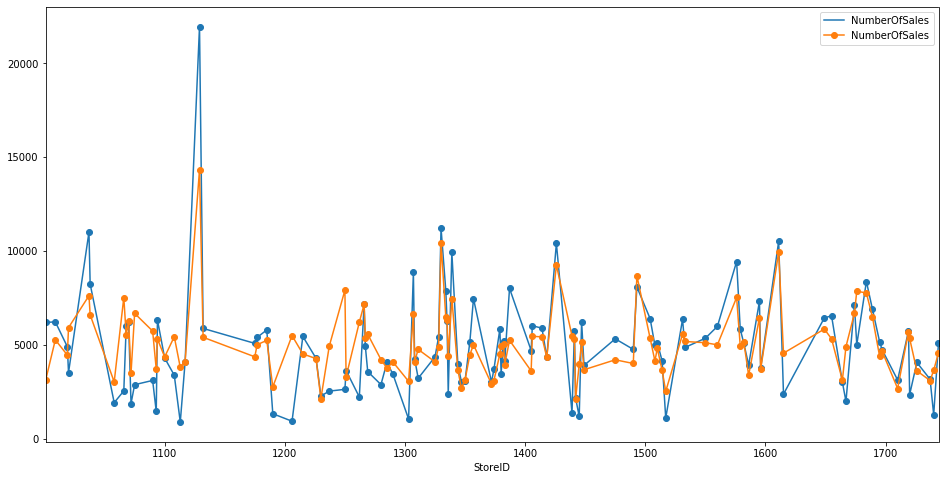

In [24]:
# For plotting reasons
holidays_open_mask = train.IsHoliday & train.IsOpen
open_mask = train['IsOpen'] == True
not_holidays_mask =  train['IsHoliday'] == False
not_holidays_open_mask = not_holidays_mask & open_mask

df_holidays_open = train[holidays_open_mask].groupby("StoreID")
avg_sales_holidays = df_holidays_open.NumberOfSales.mean()
avg_sales_holidays.plot(figsize=(16,8),legend=True,marker='o')

df_not_holidays_open = train[not_holidays_open_mask].groupby("StoreID")
avg_sales_not_holidays = df_not_holidays_open.NumberOfSales.mean()
avg_sales_not_holidays = avg_sales_not_holidays.filter(items = avg_sales_holidays.index)
avg_sales_not_holidays.plot(figsize=(16,8),legend=True,marker='o');

### Region's population density

In [25]:
all_data['Region_PD'] = all_data.Region_PopulationK.div(all_data.Region_AreaKM2, axis=0)

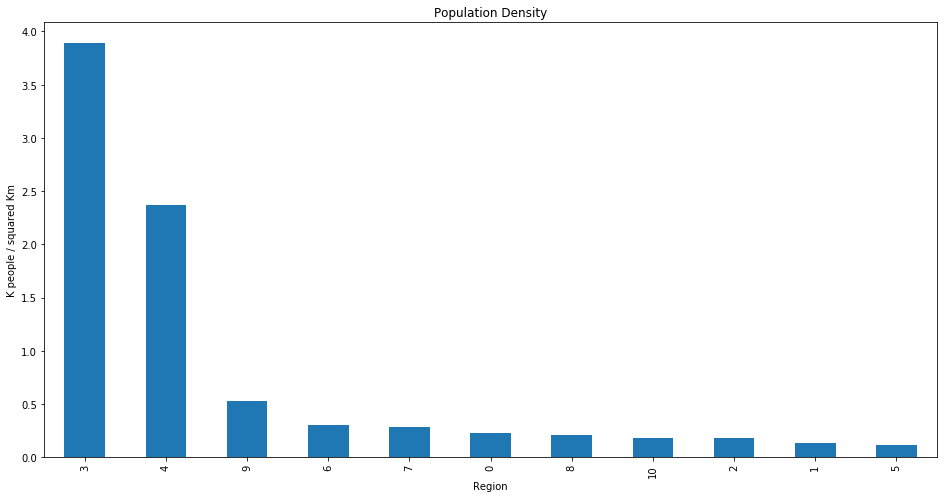

In [26]:
plot_PD = all_data.groupby("Region").Region_PD.mean().sort_values(ascending=False)\
        .plot(kind='bar', title='Population Density', figsize=(16,8));
plot_PD.set_ylabel("K people / squared Km");

### Number of stores per region

In [27]:
stores_per_region = all_data[['Region', 'StoreID']].drop_duplicates().groupby(['Region'])\
.count().rename(columns={'StoreID': 'stores_per_region'})
all_data = all_data.reset_index().merge(stores_per_region, on='Region', how='left').set_index('index')

### Number of stores per person

In [28]:
# compute stores_per_region and persons_per_region
stores_per_region = all_data[['Region', 'StoreID']].drop_duplicates().groupby(['Region'])\
.count().rename(columns={'StoreID': 'stores_per_region'})
persons_per_region = all_data[['Region', 'Region_PopulationK']]\
.drop_duplicates().set_index('Region')

# compute stores_per_person
stores_per_person = pd.merge(stores_per_region, persons_per_region, on='Region')
stores_per_person['stores_per_person'] = stores_per_person.apply(lambda x: x[0]/x[1], axis=1)
stores_per_person = stores_per_person.drop(['Region_PopulationK', 'stores_per_region'], axis=1)

# merge stores_per_person to all_data dataframe
all_data = all_data.reset_index().merge(stores_per_person, on='Region', how='left').set_index('index')

### Number of Stores per Km^2

In [29]:
# compute stores_per_region and KM2_per_region
stores_per_region = all_data[['Region', 'StoreID']].drop_duplicates()\
.groupby(['Region']).count().rename(columns={'StoreID': 'stores_per_region'})
KM2_per_region = all_data[['Region', 'Region_AreaKM2']].drop_duplicates()\
.set_index('Region')

# compute stores_per_KM2
stores_per_KM2 = pd.merge(stores_per_region, KM2_per_region, on='Region')
stores_per_KM2['stores_per_KM2'] = stores_per_KM2.apply(lambda x: x[0]/x[1], axis=1)
stores_per_KM2 = stores_per_KM2.drop(['Region_AreaKM2', 'stores_per_region'], axis=1)

# merge stores_per_KM2 to all_data dataframe
all_data = all_data.reset_index().merge(stores_per_KM2, on='Region', how='left').set_index('index')

### GDP per capita

In [30]:
# get Region_GDP and Region_PopulationK
GDP_per_capita = all_data[['Region', 'Region_GDP', 'Region_PopulationK']].drop_duplicates()\
.set_index('Region')

# compute GDP_per_capita
GDP_per_capita['GDP_per_capita'] = GDP_per_capita.apply(lambda x: x[0]/(x[1]*1000), axis=1)
GDP_per_capita = GDP_per_capita.drop(['Region_GDP', 'Region_PopulationK'], axis=1)

# merge GDP_per_capita to all_data dataframe
all_data = all_data.reset_index().merge(GDP_per_capita, on='Region', how='left').set_index('index')

### RealFeel

In [31]:
# from https://gist.githubusercontent.com/mumblepins/d4e6f2189200cbd0914e217a2e4adde9/raw/05bebe8eea8c482da0a080d6e030ce015ebae6de/realfeel.py
# Based on patent https://www.google.com/patents/US7251579
# Not responsible if you use this for anything other than personal use
from math import sqrt

def realfeel(W, #windspeed mph
            A, #pressure mb
            T, # temperature F
            UV, # UV Index
            D, # Dew Point F
            P2, # preciptation Factor from 0-5
        ):
    if W<4:
        Wa=W/2+2
    elif W<56:
        Wa=W
    else:
        Wa=56

    WSP2=(80-T)*(0.566+0.25*sqrt(Wa)-0.0166*Wa)*((sqrt(A/10))/10)
    WSP1=sqrt(W)*((sqrt(A/10))/10)

    SI2 = UV

    if D >= (55+sqrt(W)):
        Da=D
    else:
        Da=55+sqrt(W)

    H2=(Da-55-sqrt(W))**2/30

    if T>= 65:
        MFT=80-WSP2+SI2+H2-P2
    else:
        MFT=T-WSP1+SI2+H2-P2
    
    return MFT

In [32]:
real_feel = all_data[['Precipitationmm', 'Mean_Dew_PointC', 'Mean_TemperatureC', 'Mean_Sea_Level_PressurehPa', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'Date']].copy()

In [33]:
# compute uv_index estimation
# based on https://science.howstuffworks.com/nature/climate-weather/atmospheric/question160.htm
real_feel['season_weight'] = real_feel.Date.dt.quarter.apply(lambda q: 2 if q==4 else q)
real_feel['uv_index'] = real_feel[['season_weight', 'CloudCover']].apply(lambda x: (x[0]+1)/(x[1]+1), axis=1)

# scale to max 5 uv index as nordic countries have low uv index
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0, 5))
real_feel['uv_index'] = mms.fit_transform(real_feel[['uv_index']].values).astype(int)

In [34]:
real_feel.head()

,Precipitationmm,Mean_Dew_PointC,Mean_TemperatureC,Mean_Sea_Level_PressurehPa,Mean_Wind_SpeedKm_h,CloudCover,Date,season_weight,uv_index
index,,,,,,,,,
0,0.0,-1,1,1030,16,8.0,2016-03-01,1,0
1,0.0,-1,3,1027,10,8.0,2016-03-02,1,0
2,0.0,-1,3,1024,10,8.0,2016-03-04,1,0
3,0.0,-4,3,1024,10,6.0,2016-03-05,1,0
4,0.0,-3,1,1023,5,6.0,2016-03-06,1,0


In [36]:
# temperatures to fahreneit
to_fahreneit = lambda c: c * 9/5 + 32

real_feel['Mean_Dew_PointC'] = real_feel['Mean_Dew_PointC'].apply(to_fahreneit)
real_feel['Mean_TemperatureC'] = real_feel['Mean_TemperatureC'].apply(to_fahreneit)

In [37]:
# speed to mph
to_mph = lambda kmh: 0.6214 * kmh

real_feel['Mean_Wind_SpeedKm_h'] = real_feel['Mean_Wind_SpeedKm_h'].apply(to_mph)

In [38]:
# pa to mb
to_mb = lambda pa: pa / 10

real_feel['Mean_Sea_Level_PressurehPa'] = real_feel['Mean_Sea_Level_PressurehPa'].apply(to_mb)

In [39]:
# rescale precipitation
mms = MinMaxScaler(feature_range=(0, 5))
real_feel['Precipitationmm'] = mms.fit_transform(real_feel[['Precipitationmm']].values).astype(int)

In [40]:
# compute RealFeel
real_feel['real_feel'] =\
real_feel.apply(lambda x: realfeel(x['Mean_Wind_SpeedKm_h'], x['Mean_Sea_Level_PressurehPa'],
                                   x['Mean_TemperatureC'], x['uv_index'],
                                   x['Mean_Dew_PointC'], x['Precipitationmm']), axis=1)

In [41]:
# add real feel to dataset
all_data['real_feel'] = real_feel['real_feel']

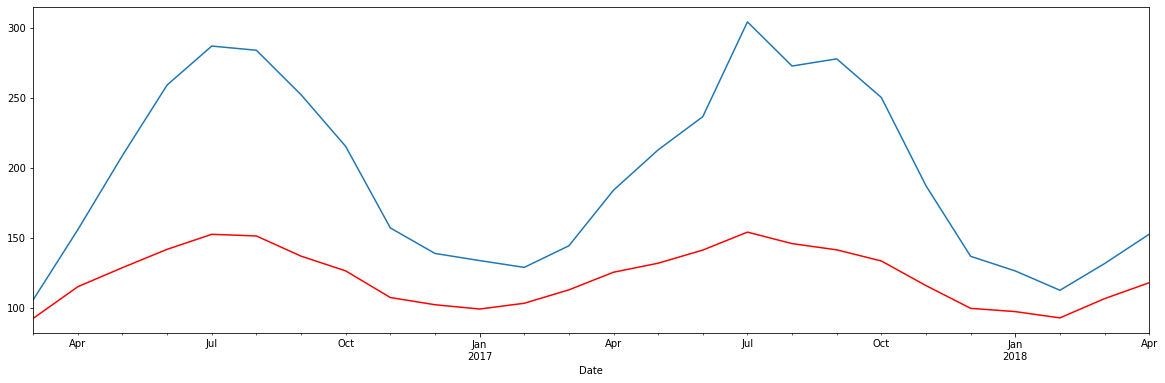

In [42]:
# plot real feel
real_feel_monthly = real_feel.groupby([pd.Grouper(key='Date',freq='M')]).mean().reset_index()

pd.Series(real_feel_monthly['real_feel'].values, index=real_feel_monthly['Date'])\
.plot(figsize=(20,6))
pd.Series(real_feel_monthly['Mean_TemperatureC'].values, index=real_feel_monthly['Date'])\
.plot(figsize=(20,6), color='red')

plt.show()

## Seasonality features

In [43]:
def week_of_month(tgtdate):
    tgtdate = pd.to_datetime(tgtdate)

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    return (tgtdate - startdate).days //7 + 1

all_data['week_of_month'] = all_data.Date.apply(week_of_month)
all_data['year'] = all_data.Date.dt.year
all_data['quarter'] = all_data.Date.dt.quarter
all_data['month'] = all_data.Date.dt.month
all_data['day_of_month'] = all_data.Date.dt.day
all_data['day_of_week'] = all_data.Date.dt.dayofweek
all_data['day_of_year'] = all_data.Date.dt.dayofyear
all_data['WeekOfYear'] = all_data.Date.dt.weekofyear
all_data['days_in_month'] = all_data.Date.dt.daysinmonth

## One-Hot encoding

#### Add Hail single event

In [44]:
# all features which contain 'Hails'
event_list = all_data.Events.unique()
hail_list = [feature for feature in event_list if 'Hail' in feature.split('-')]

In [45]:
# create Hails feature and concatenate it to the dataset
hail_feature = all_data.Events.isin(hail_list).rename('Events_Hail')
all_data = pd.concat([all_data, hail_feature], axis=1)

#### Perform One Hot Encoding

In [46]:
all_data_reg_temp = all_data['Region']
all_data = pd.get_dummies(all_data,columns=['Region','AssortmentType', 'StoreType', 'Events'])
all_data['Region'] = all_data_reg_temp

#### Drop combined Events

In [47]:
events_to_drop = ['Events_'+feature for feature in event_list if '-' in feature]
all_data = all_data.drop(events_to_drop, axis=1)

## New Features Holidays

In [48]:
def num_of_features(regional_week_year, week, year, column_of_interest):
    num_holidays = 0

    if week == 1:
        week_before = [52,year-1]
        week_after = [2,year]
    if week == 52:
        week_after = [1,year+1]
        week_before = [51,year]
    if (week>1) & (week<52):
        week_before = [week-1,year]
        week_after = [week+1,year]
    
    before_df = regional_week_year[(regional_week_year['WeekOfYear']==week_before[0])&
                                  (regional_week_year['year']==week_before[1])]
    
    after_df = regional_week_year[(regional_week_year['WeekOfYear']==week_after[0])&
                                  (regional_week_year['year']==week_after[1])]
    this_df = regional_week_year[(regional_week_year['WeekOfYear']==week)&
                                 (regional_week_year['year']==year)]
    
    num_ago = before_df[before_df[column_of_interest]][column_of_interest].sum()
    num_next = after_df[after_df[column_of_interest]][column_of_interest].sum()
    num_this = this_df[this_df[column_of_interest]][column_of_interest].sum()
    
    return num_ago, num_next, num_this

def create_new_features(before,current,after,column_of_interest):
    all_data[before] = 0
    all_data[current] = 0
    all_data[after] = 0

    region_list= ["Region_"+str(d) for d in range(0,11)]
    for region in tqdm(region_list):
        curr_region = all_data[all_data[region]==1]

        #get all valid dates of that region
        regional_week_year=curr_region[['WeekOfYear','year',column_of_interest]]

        #get all store ids of that region
        regional_stores=len(curr_region['StoreID'].unique())

        week_year_list =regional_week_year[['WeekOfYear','year']].drop_duplicates().values.tolist()

        for date in week_year_list:
            num_ago,num_next,num_this = num_of_features(regional_week_year,
                                                        date[0],
                                                        date[1],
                                                        column_of_interest)

            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),before]=int(num_ago/regional_stores)
            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),after]=int(num_next/regional_stores)
            all_data.at[((all_data['WeekOfYear']==date[0])&
                         (all_data['year']==date[1])),current]=int(num_this/regional_stores)

In [49]:
create_new_features('HolidaysWeekBefore', 'HolidaysWeekCurrent', 'HolidaysWeekAfter','IsHoliday')
create_new_features('PromoWeekBefore', 'PromoWeekCurrent', 'PromoWeekAfter', 'HasPromotions')

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:56<00:00, 10.60s/it]


## Split train and test

In [50]:
train_final = all_data[:train.shape[0]].copy()
train_final['NumberOfSales'] = train.NumberOfSales

# extract the test examples (we don't have the class value for this)
test_final = all_data[train.shape[0]:]

## Add differential feature (on train set)

In [51]:
## Activate Differential
act_differential = False

if act_differential == True:
    march_2016  = datetime.date(2016,3,31)
    monthly_sales['Differential'] = 0        

    for storeID, store in tqdm(monthly_sales.groupby('StoreID')):
        monthly_sales.loc[store.index,'one_step'] = store['NumberOfSales'].shift(1).fillna(0)
        monthly_sales.loc[store.index,'two_steps'] = store['NumberOfSales'].shift(2).fillna(0)

In [52]:
if act_differential == True:
    train_final['Differential'] = 0

    #correct one step in april
    april_mask = monthly_sales.Date.dt.month == 4
    year_mask = monthly_sales.Date.dt.year == 2016
    monthly_sales.loc[year_mask & april_mask,'one_step'] = 0

    #compute differential
    monthly_sales['Differential'] = monthly_sales['one_step'] - monthly_sales['two_steps']
    pippo = monthly_sales[['StoreID','Date','Differential']]

    #longest for ever - more than 10 mins - there must be a better way..
    for index,row in tqdm(pippo.iterrows()):
        differential = row.Differential
        month = row.Date.month
        year = row.Date.year
        store = row.StoreID
        month_mask = train_final.Date.dt.month == month
        year_mask = train_final.Date.dt.year == year
        store_mask = train_final.StoreID == store

        train_final.loc[store_mask & year_mask & month_mask,'Differential'] = differential


## Save Train and Test

In [53]:
# train_final.to_csv(data_path_out+'train_final.csv')
# test_final.to_csv(data_path_out+'test_final.csv')

# Serialize dataframes for later use in implementations
with open(data_path_out+'train_pp.obj', 'wb') as file:
        pickle.dump(train_final, file)
with open(data_path_out+'test_pp.obj', 'wb') as file:
        pickle.dump(test_final, file)